In [1]:
from sklearn.metrics import classification_report 
from keras.utils import to_categorical
from keras.optimizers import *
import matplotlib.pyplot as plt
#import keras
from tensorflow.keras import *
import pandas as pd
import numpy as np
import string

In [2]:
train_file = 'dataset/A_Z Handwritten Data.csv'
N_CLASSES = 26

## فاز اول: بررسی و پیش پردازش داده
+  با کمک متاد read_csv از کتابخانه pandas فایل مورد نظر خوانده شده است. برای راحتی، در ادامه از کتابخانه‌ی numpy استفاده شده است. 

In [3]:
df = pd.read_csv(train_file ,header=None)

In [4]:
raw = df.to_numpy()
num_images = raw.shape[0]

+  داده‌ها و برچسب متناظر هریک از آن‌ها به کمک تابع load_data از یکدیگر جدا شده‌اند.

In [5]:
def load_data(raw):
    np.random.shuffle(raw)
    labels = raw[:, 0]
    images = raw[:, 1:num_images]
    return images, labels

images, labels = load_data(raw)

In [6]:
num_images

372451

In [7]:
image_label, image_count = np.unique(labels, return_counts=True)

In [8]:
len(image_label)

26

+  متغیرهای num_images و image_label به ترتیب برابر با تعداد تصاویر و کلاس های موجود می باشد. 

In [9]:
label_dict =  {}
for i, ch in enumerate(string.ascii_uppercase):
    label_dict[i] = ch

+  کد زیر نمودار میله ای  تعداد تصاویر هر کلاس را رسم می کند. 

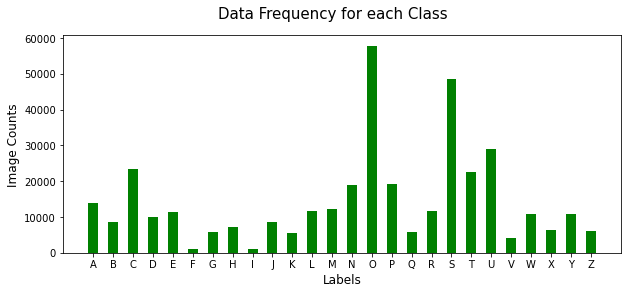

In [10]:
barWidth = 0.5
fig = plt.figure(figsize=(10, 4))
plt.bar(image_label, image_count, color ='g', width = barWidth) 
plt.xlabel('Labels', fontsize = 12)
plt.ylabel('Image Counts', fontsize = 12)
x_labels = label_dict.values()
plt.suptitle('Data Frequency for each Class', fontsize = 15)
plt.xticks(range(len(x_labels)), x_labels)
plt.show()

+  از هر کلاس یک تصویر به همراه نام کلاس رسم شده است.

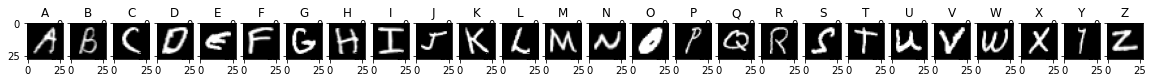

In [11]:
classes = label_dict.values()
num_classes = len(classes)
samples_per_class = 1

fig, ax = plot_container = plt.subplots(1, 26)
fig.set_size_inches(20, 10)


cursor = 0
samples_per_class = 1
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(labels == y)
    idx = np.random.choice(idxs, samples_per_class, replace=False)
    ax[cursor].imshow(images[idx].reshape(28, 28), cmap='gray')
    ax[cursor].set_title(cls)
    cursor += 1

+  دیتاست به دو بخش train و test تقسیم شده است تعداد داده های تست 10000 نمونه می باشد و باقی داده ها به train اختصاص داده شده است.

In [12]:
X_test, y_test = images[-10000:], labels[-10000:]
X_train, y_train = images[:num_images - 10000], labels[:num_images - 10000]

+  داده های train و test را بر 255 تقسیم کرده تا scale شود.

In [13]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

+  برای کلاس های categorical باید کلاس‌های متفاوت را به روش One Hot کد بندی کرد. درواقع چون خروجی شبکه عصبی به تعداد کلاس ها می باشد و در صورت شباهت داده با هر کلاس یک خروجی مشخص دارای بیشترین مقدار خواهد شد باید label ها نیز به صورت one hot در نظر گرفته شود. کد زیر label های train و test را به فرم one  hot کد می کند.

In [14]:
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
y_test = utils.to_categorical(y_test, N_CLASSES)
y_train = utils.to_categorical(y_train, N_CLASSES)

## فاز دوم: طراحی شبکه عصبی

In [15]:
def categorical_to_normal(labels):
    return np.array(backend.argmax(labels))

In [16]:
def print_metrics(y_true, y_pred):
    print(classification_report(y_true, y_pred))

In [17]:
def predict(model, X, y):
    y_pred = categorical_to_normal(model.predict(X))
    true_outputs = categorical_to_normal(y)
    print_metrics(true_outputs, y_pred)

In [18]:
def make_feedforward_network(neurons_1st_dense, neurons_2nd_dense, activation='relu', 
                             optimizer=optimizers.SGD(lr = 0.01), loss=losses.categorical_crossentropy, 
                             regularizer=None):
    inp = layers.Input(shape=(28, 28, 1))
    out = layers.Flatten()(inp)
    out = layers.Dense(neurons_1st_dense, activation=activation, kernel_regularizer=regularizer)(out)
    
    out = layers.Dense(neurons_2nd_dense, activation=activation, kernel_regularizer=regularizer)(out)
    out = layers.Dense(N_CLASSES, activation="softmax")(out)

    model = models.Model(inputs=inp, outputs=out) 
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])  
    return model

In [19]:
relu_model = make_feedforward_network(320, 160)  

+  شبکه عصبی با 320 و 160 نورون در لایه اول و دوم میانی طراحی شده است.  با توجه به توضیحات مساله learning rate برابر با 0.01 اختیار شده است در ادامه تعداد پارامترهای شبکه به کمک متد summary آمده است.

In [20]:
relu_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 320)               251200    
_________________________________________________________________
dense_1 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_2 (Dense)              (None, 26)                4186      
Total params: 306,746
Trainable params: 306,746
Non-trainable params: 0
_________________________________________________________________


## فاز سوم: طبقه بندی داده‌ها


In [21]:
relu_history = relu_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
11327/11327 [==============================] - 38s 3ms/step - loss: 0.5516 - accuracy: 0.8532 - val_loss: 0.3182 - val_accuracy: 0.9164
Epoch 2/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.2415 - accuracy: 0.9358 - val_loss: 0.2047 - val_accuracy: 0.9463
Epoch 3/10
11327/11327 [==============================] - 17s 2ms/step - loss: 0.1713 - accuracy: 0.9547 - val_loss: 0.1618 - val_accuracy: 0.9566
Epoch 4/10
11327/11327 [==============================] - 17s 1ms/step - loss: 0.1373 - accuracy: 0.9634 - val_loss: 0.1389 - val_accuracy: 0.9604
Epoch 5/10
11327/11327 [==============================] - 17s 1ms/step - loss: 0.1162 - accuracy: 0.9689 - val_loss: 0.1246 - val_accuracy: 0.9655
Epoch 6/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.1012 - accuracy: 0.9730 - val_loss: 0.1050 - val_accuracy: 0.9711
Epoch 7/10
11327/11327 [==============================] - 17s 1ms/step - loss: 0.0899 - accuracy: 0.9759 - val_loss: 0

In [22]:
def plot_loss(history):
    fig = plt.figure(figsize=(15, 10))
    plt.plot(history.history['loss'], linewidth = 3, color = '#e500a9')
    plt.plot(history.history['val_loss'], linewidth = 3, color = '#9a34b5')
    plt.title('Model Loss', fontsize = 15)
    plt.ylabel('Loss', fontsize = 12)
    plt.xlabel('Epoch', fontsize = 12)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [23]:
def plot_accuracy(history):
    fig = plt.figure(figsize=(15, 10))
    plt.plot(history.history['accuracy'], linewidth = 3, color = '#e598ff')
    plt.plot(history.history['val_accuracy'], linewidth = 3, color = '#9aa3f0')
    plt.title('Model Accuracy', fontsize = 15)
    plt.ylabel('accuracy', fontsize = 12)
    plt.xlabel('Epoch', fontsize = 12)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [24]:
predict(relu_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       417
           1       0.96      0.96      0.96       231
           2       0.99      0.98      0.98       625
           3       0.95      0.94      0.95       284
           4       0.97      0.97      0.97       273
           5       1.00      0.93      0.96        43
           6       0.98      0.96      0.97       166
           7       0.95      0.93      0.94       176
           8       0.97      0.97      0.97        34
           9       0.98      0.95      0.97       244
          10       0.93      0.95      0.94       162
          11       0.98      0.99      0.99       312
          12       0.98      0.98      0.98       310
          13       0.96      0.99      0.97       539
          14       0.99      0.98      0.99      1507
          15       0.97      0.99      0.98       517
          16       0.97      0.96      0.97       151
          17       0.98    

In [25]:
predict(relu_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     13453
           1       0.98      0.98      0.98      8437
           2       0.99      0.98      0.99     22784
           3       0.96      0.96      0.96      9850
           4       0.98      0.98      0.98     11167
           5       0.96      0.95      0.96      1120
           6       0.98      0.95      0.96      5596
           7       0.96      0.97      0.97      7042
           8       0.97      0.94      0.95      1086
           9       0.98      0.96      0.97      8249
          10       0.97      0.96      0.96      5441
          11       0.97      0.99      0.98     11274
          12       0.99      0.98      0.98     12026
          13       0.97      0.99      0.98     18471
          14       0.99      0.99      0.99     56318
          15       0.97      0.99      0.98     18824
          16       0.97      0.97      0.97      5661
          17       0.99    

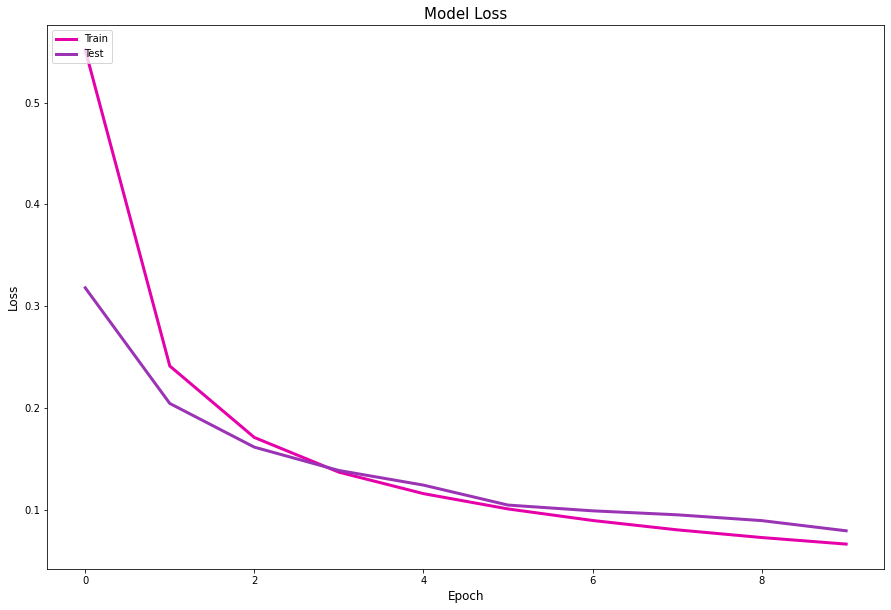

In [26]:
plot_loss(relu_history)

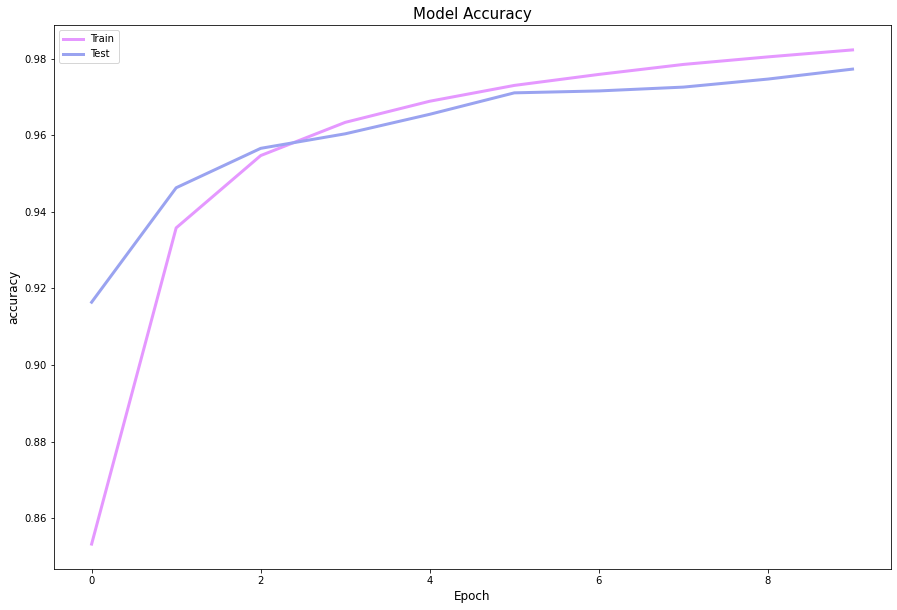

In [27]:
plot_accuracy(relu_history)

In [28]:
tanh_model = make_feedforward_network(320, 160, activation='tanh')  

In [29]:
tanh_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 320)               251200    
_________________________________________________________________
dense_4 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_5 (Dense)              (None, 26)                4186      
Total params: 306,746
Trainable params: 306,746
Non-trainable params: 0
_________________________________________________________________


In [30]:
tanh_history = tanh_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.5782 - accuracy: 0.8477 - val_loss: 0.3828 - val_accuracy: 0.8955
Epoch 2/10
11327/11327 [==============================] - 19s 2ms/step - loss: 0.3139 - accuracy: 0.9173 - val_loss: 0.2731 - val_accuracy: 0.9255
Epoch 3/10
11327/11327 [==============================] - 17s 2ms/step - loss: 0.2332 - accuracy: 0.9391 - val_loss: 0.2156 - val_accuracy: 0.9449
Epoch 4/10
11327/11327 [==============================] - 18s 2ms/step - loss: 0.1885 - accuracy: 0.9509 - val_loss: 0.1807 - val_accuracy: 0.9518
Epoch 5/10
11327/11327 [==============================] - 21s 2ms/step - loss: 0.1598 - accuracy: 0.9583 - val_loss: 0.1593 - val_accuracy: 0.9589
Epoch 6/10
11327/11327 [==============================] - 22s 2ms/step - loss: 0.1397 - accuracy: 0.9634 - val_loss: 0.1412 - val_accuracy: 0.9632
Epoch 7/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.1245 - accuracy: 0.9674 - val_loss: 0

In [31]:
predict(tanh_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       417
           1       0.96      0.95      0.95       231
           2       0.98      0.98      0.98       625
           3       0.92      0.93      0.93       284
           4       0.97      0.96      0.96       273
           5       0.97      0.84      0.90        43
           6       0.98      0.96      0.97       166
           7       0.94      0.90      0.92       176
           8       0.97      0.97      0.97        34
           9       0.97      0.93      0.95       244
          10       0.92      0.96      0.94       162
          11       0.98      0.99      0.99       312
          12       0.96      0.98      0.97       310
          13       0.95      0.97      0.96       539
          14       0.98      0.99      0.98      1507
          15       0.98      0.98      0.98       517
          16       0.96      0.92      0.94       151
          17       0.97    

In [32]:
predict(relu_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     13453
           1       0.98      0.98      0.98      8437
           2       0.99      0.98      0.99     22784
           3       0.96      0.96      0.96      9850
           4       0.98      0.98      0.98     11167
           5       0.96      0.95      0.96      1120
           6       0.98      0.95      0.96      5596
           7       0.96      0.97      0.97      7042
           8       0.97      0.94      0.95      1086
           9       0.98      0.96      0.97      8249
          10       0.97      0.96      0.96      5441
          11       0.97      0.99      0.98     11274
          12       0.99      0.98      0.98     12026
          13       0.97      0.99      0.98     18471
          14       0.99      0.99      0.99     56318
          15       0.97      0.99      0.98     18824
          16       0.97      0.97      0.97      5661
          17       0.99    

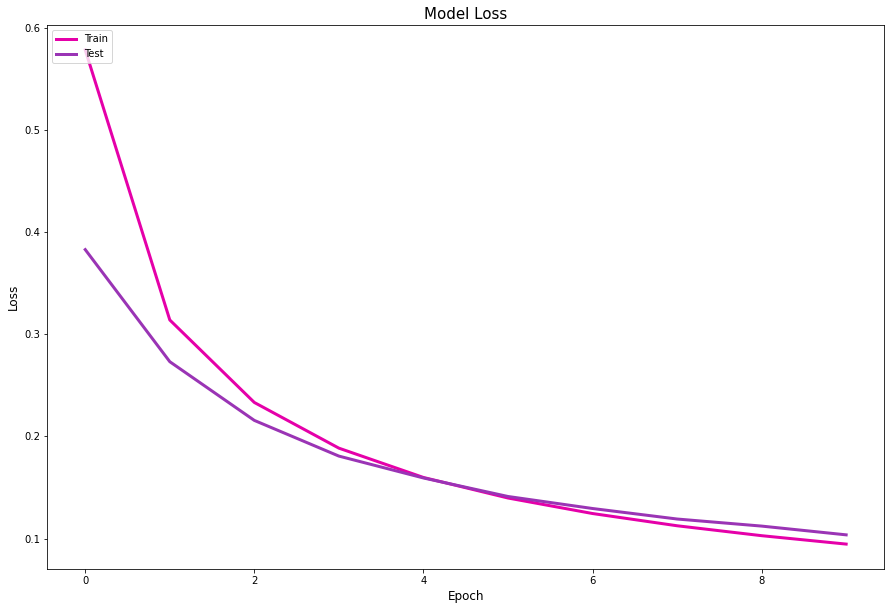

In [33]:
plot_loss(tanh_history)

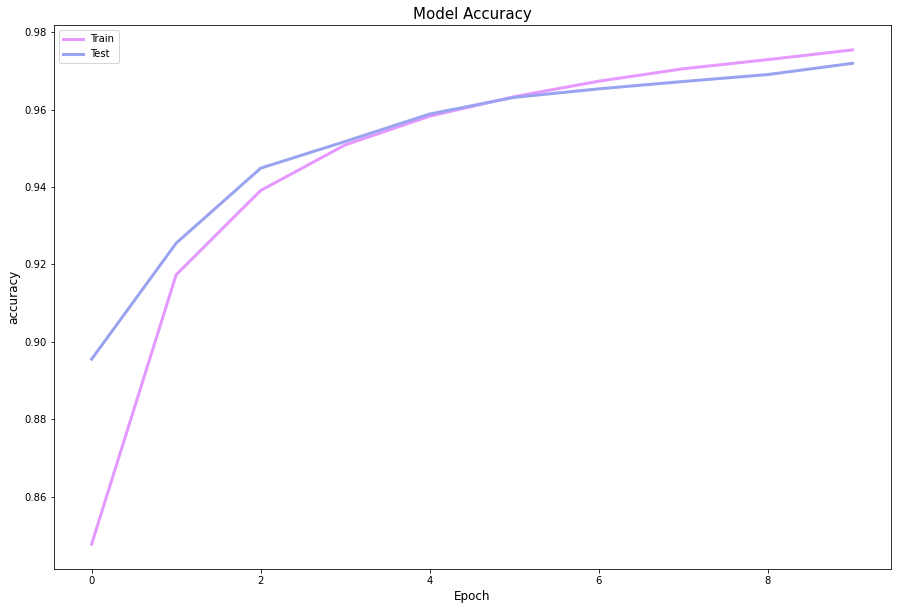

In [34]:
plot_accuracy(tanh_history)

In [35]:
sigmoid_model = make_feedforward_network(320, 160, activation='sigmoid') 

In [36]:
sigmoid_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 320)               251200    
_________________________________________________________________
dense_7 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_8 (Dense)              (None, 26)                4186      
Total params: 306,746
Trainable params: 306,746
Non-trainable params: 0
_________________________________________________________________


In [37]:
sigmoid_history = sigmoid_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
11327/11327 [==============================] - 20s 2ms/step - loss: 1.8793 - accuracy: 0.4741 - val_loss: 1.1662 - val_accuracy: 0.6736
Epoch 2/10
11327/11327 [==============================] - 26s 2ms/step - loss: 0.9223 - accuracy: 0.7459 - val_loss: 0.7675 - val_accuracy: 0.7904
Epoch 3/10
11327/11327 [==============================] - 29s 3ms/step - loss: 0.6918 - accuracy: 0.8107 - val_loss: 0.6333 - val_accuracy: 0.8269
Epoch 4/10
11327/11327 [==============================] - 22s 2ms/step - loss: 0.5920 - accuracy: 0.8381 - val_loss: 0.5596 - val_accuracy: 0.8455
Epoch 5/10
11327/11327 [==============================] - 21s 2ms/step - loss: 0.5322 - accuracy: 0.8550 - val_loss: 0.5111 - val_accuracy: 0.8600
Epoch 6/10
11327/11327 [==============================] - 18s 2ms/step - loss: 0.4889 - accuracy: 0.8672 - val_loss: 0.4744 - val_accuracy: 0.8679
Epoch 7/10
11327/11327 [==============================] - 17s 1ms/step - loss: 0.4534 - accuracy: 0.8768 - val_loss: 0

In [38]:
predict(sigmoid_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       417
           1       0.89      0.80      0.84       231
           2       0.95      0.91      0.93       625
           3       0.83      0.82      0.82       284
           4       0.81      0.83      0.82       273
           5       1.00      0.70      0.82        43
           6       0.88      0.80      0.84       166
           7       0.82      0.69      0.75       176
           8       0.91      0.85      0.88        34
           9       0.86      0.81      0.84       244
          10       0.77      0.77      0.77       162
          11       0.95      0.96      0.95       312
          12       0.85      0.92      0.88       310
          13       0.83      0.86      0.84       539
          14       0.95      0.97      0.96      1507
          15       0.90      0.95      0.93       517
          16       0.82      0.80      0.81       151
          17       0.85    

In [39]:
predict(sigmoid_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     13453
           1       0.88      0.80      0.84      8437
           2       0.94      0.93      0.93     22784
           3       0.85      0.82      0.84      9850
           4       0.85      0.82      0.83     11167
           5       0.94      0.72      0.82      1120
           6       0.85      0.79      0.81      5596
           7       0.81      0.74      0.77      7042
           8       0.89      0.68      0.77      1086
           9       0.84      0.82      0.83      8249
          10       0.79      0.75      0.77      5441
          11       0.93      0.94      0.93     11274
          12       0.86      0.91      0.89     12026
          13       0.84      0.86      0.85     18471
          14       0.95      0.98      0.96     56318
          15       0.92      0.95      0.93     18824
          16       0.82      0.78      0.80      5661
          17       0.82    

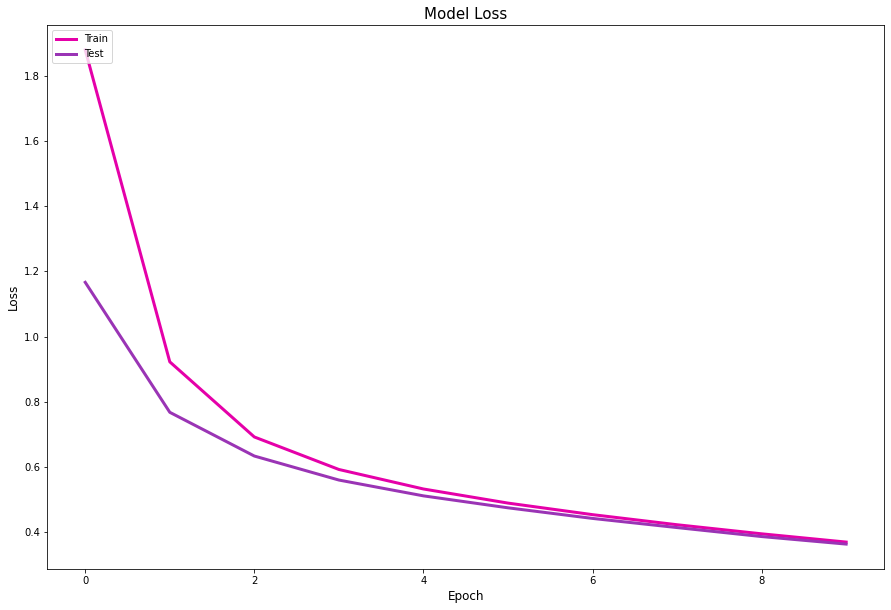

In [40]:
plot_loss(sigmoid_history)

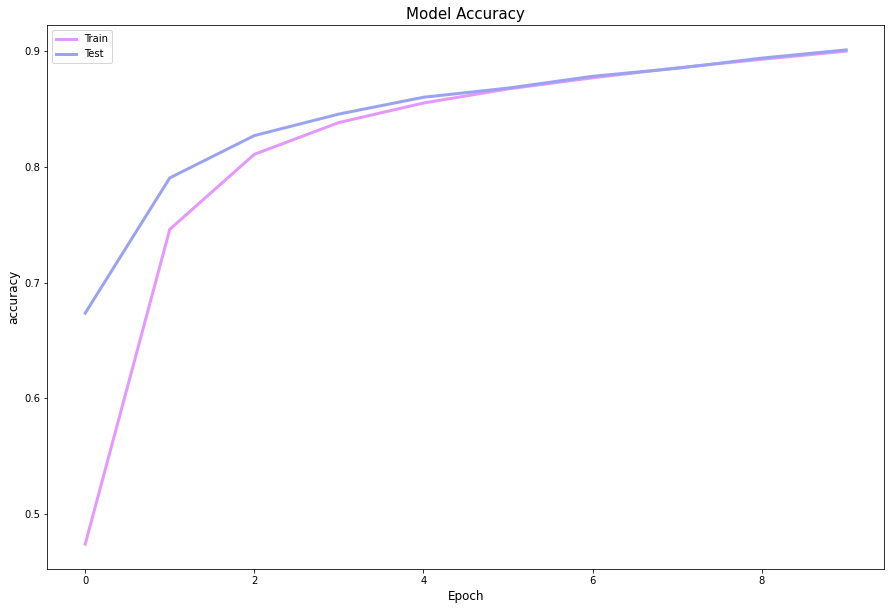

In [41]:
plot_accuracy(sigmoid_history)

## بررسی تاثیر تغییرات مختلف و سوالات
### قسمت اول) تاثیر optimizer:
+ به منظور کم کردن خطا در روش گرادیان از تکنیکی به نام Momentum استفاده می‌شود. در این روش به‌جای اینکه تنها از مقدار گرادیان در مرحله فعلی استفاده شود Momentum نیز محاسبه شده و از آن برای تعیین جهت گرادیان استفاده می‌شود. این روش باعث می‌شود که گرادیان در جهت درست شتاب داده شود. Momentum میانگینی از گرادیان‌های پیشین می‌باشد که در طول زمان تغییر می‌کند. در شبکه‌های عمیق که اندازه‌ی داده‌ها بسیار بزرگ می‌باشد استفاده Momentum مناسب تفاوت زمانی قابل توجهی در حین آموزش ایجاد می‌کند. اگر گرادیان با حرکات زیگزاگی زیادی تغییر کند باز هم استفاده از Momentum باعث بهبود فرآیند آموزش می‌شود. 

+  در ادامه مدل‌سازی برای مقادیر متفاوت Momentum انجام شده است.

### Momentum=0.5

In [42]:
momentum_0_5_model = make_feedforward_network(320, 160, optimizer=optimizers.SGD(momentum=0.5)) 

In [43]:
momentum_0_5_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 320)               251200    
_________________________________________________________________
dense_10 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_11 (Dense)             (None, 26)                4186      
Total params: 306,746
Trainable params: 306,746
Non-trainable params: 0
_________________________________________________________________


In [44]:
momentum_0_5_history = momentum_0_5_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.4029 - accuracy: 0.8914 - val_loss: 0.2147 - val_accuracy: 0.9414
Epoch 2/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.1606 - accuracy: 0.9564 - val_loss: 0.1442 - val_accuracy: 0.9610
Epoch 3/10
11327/11327 [==============================] - 25s 2ms/step - loss: 0.1149 - accuracy: 0.9687 - val_loss: 0.1138 - val_accuracy: 0.9669
Epoch 4/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.0921 - accuracy: 0.9750 - val_loss: 0.0984 - val_accuracy: 0.9705
Epoch 5/10
11327/11327 [==============================] - 19s 2ms/step - loss: 0.0771 - accuracy: 0.9790 - val_loss: 0.0902 - val_accuracy: 0.9733
Epoch 6/10
11327/11327 [==============================] - 18s 2ms/step - loss: 0.0658 - accuracy: 0.9822 - val_loss: 0.0822 - val_accuracy: 0.9765
Epoch 7/10
11327/11327 [==============================] - 22s 2ms/step - loss: 0.0573 - accuracy: 0.9845 - val_loss: 0

In [45]:
predict(momentum_0_5_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       417
           1       0.99      0.96      0.97       231
           2       0.99      0.99      0.99       625
           3       0.97      0.98      0.97       284
           4       0.99      0.98      0.99       273
           5       1.00      0.98      0.99        43
           6       0.99      0.97      0.98       166
           7       0.98      0.94      0.96       176
           8       1.00      0.97      0.99        34
           9       0.96      0.97      0.97       244
          10       0.95      0.95      0.95       162
          11       1.00      0.99      0.99       312
          12       0.99      0.98      0.98       310
          13       0.98      0.99      0.98       539
          14       0.99      0.99      0.99      1507
          15       0.99      0.99      0.99       517
          16       0.99      0.95      0.97       151
          17       0.96    

In [46]:
predict(momentum_0_5_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13453
           1       0.99      0.99      0.99      8437
           2       0.99      0.99      0.99     22784
           3       0.98      0.98      0.98      9850
           4       0.99      0.99      0.99     11167
           5       0.93      0.98      0.96      1120
           6       0.99      0.97      0.98      5596
           7       0.99      0.98      0.98      7042
           8       1.00      0.97      0.98      1086
           9       0.98      0.99      0.99      8249
          10       0.99      0.98      0.98      5441
          11       1.00      0.99      0.99     11274
          12       1.00      0.99      0.99     12026
          13       0.99      0.99      0.99     18471
          14       0.99      1.00      0.99     56318
          15       1.00      0.99      1.00     18824
          16       0.99      0.98      0.98      5661
          17       0.99    

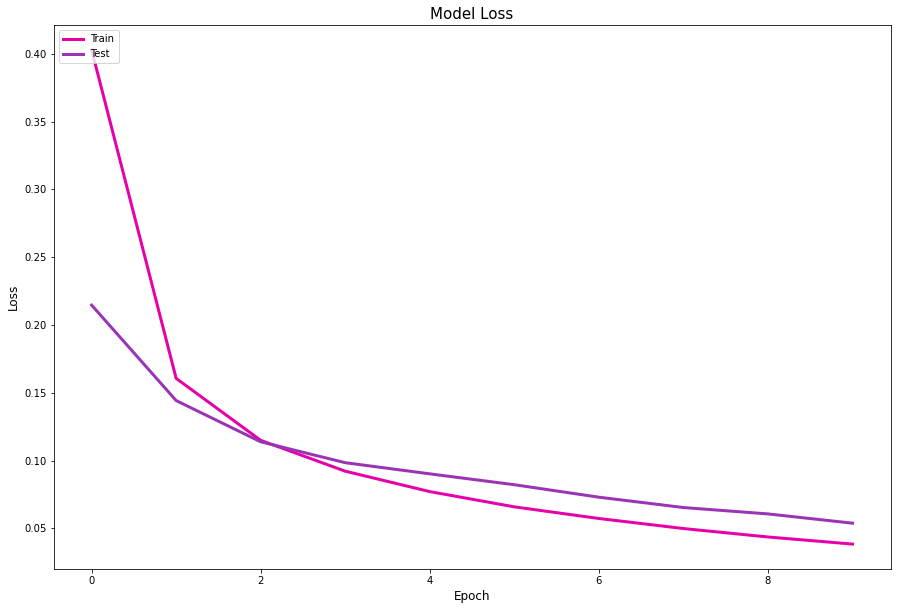

In [47]:
plot_loss(momentum_0_5_history)

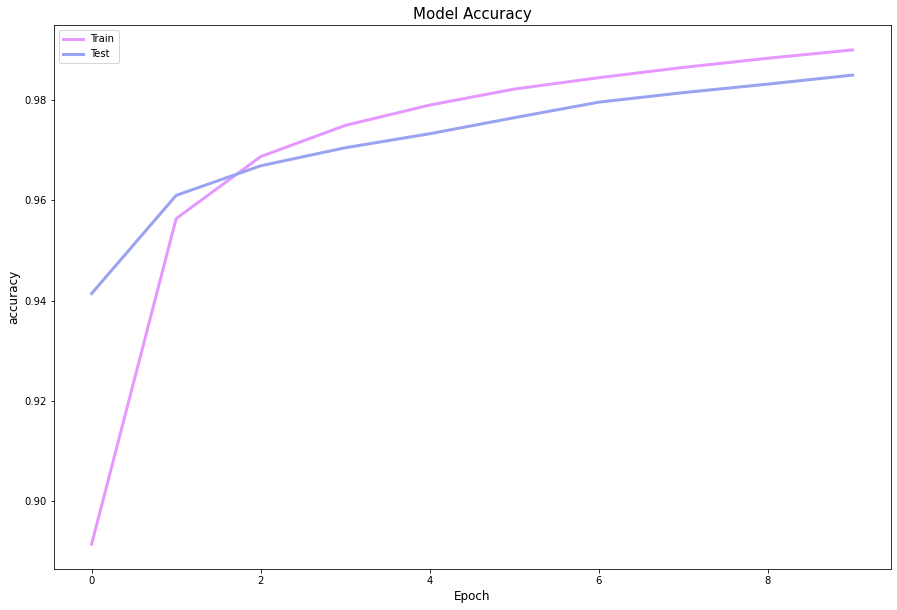

In [48]:
plot_accuracy(momentum_0_5_history)

### Momentum=0.9

In [49]:
momentum_0_9_model = make_feedforward_network(320, 160, optimizer=optimizers.SGD(momentum=0.9)) 

In [50]:
momentum_0_9_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 320)               251200    
_________________________________________________________________
dense_13 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_14 (Dense)             (None, 26)                4186      
Total params: 306,746
Trainable params: 306,746
Non-trainable params: 0
_________________________________________________________________


In [51]:
momentum_0_9_history = momentum_0_9_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.2147 - accuracy: 0.9399 - val_loss: 0.1227 - val_accuracy: 0.9626
Epoch 2/10
11327/11327 [==============================] - 21s 2ms/step - loss: 0.0871 - accuracy: 0.9749 - val_loss: 0.0824 - val_accuracy: 0.9752
Epoch 3/10
11327/11327 [==============================] - 22s 2ms/step - loss: 0.0599 - accuracy: 0.9823 - val_loss: 0.0703 - val_accuracy: 0.9807
Epoch 4/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.0437 - accuracy: 0.9868 - val_loss: 0.0575 - val_accuracy: 0.9834
Epoch 5/10
11327/11327 [==============================] - 23s 2ms/step - loss: 0.0329 - accuracy: 0.9898 - val_loss: 0.0477 - val_accuracy: 0.9856
Epoch 6/10
11327/11327 [==============================] - 20s 2ms/step - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.0441 - val_accuracy: 0.9875
Epoch 7/10
11327/11327 [==============================] - 19s 2ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0

In [52]:
predict(momentum_0_9_model, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       417
           1       1.00      0.97      0.99       231
           2       1.00      1.00      1.00       625
           3       0.99      0.93      0.96       284
           4       0.98      1.00      0.99       273
           5       1.00      0.95      0.98        43
           6       1.00      0.98      0.99       166
           7       0.98      0.99      0.99       176
           8       1.00      1.00      1.00        34
           9       1.00      0.99      1.00       244
          10       0.98      0.99      0.99       162
          11       1.00      1.00      1.00       312
          12       0.99      1.00      1.00       310
          13       1.00      0.99      1.00       539
          14       0.99      1.00      0.99      1507
          15       0.99      0.99      0.99       517
          16       0.99      0.98      0.99       151
          17       0.99    

In [53]:
predict(momentum_0_9_model, X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13453
           1       1.00      1.00      1.00      8437
           2       1.00      1.00      1.00     22784
           3       1.00      0.95      0.98      9850
           4       1.00      1.00      1.00     11167
           5       1.00      0.99      1.00      1120
           6       1.00      1.00      1.00      5596
           7       1.00      1.00      1.00      7042
           8       1.00      1.00      1.00      1086
           9       1.00      1.00      1.00      8249
          10       1.00      1.00      1.00      5441
          11       1.00      1.00      1.00     11274
          12       1.00      1.00      1.00     12026
          13       1.00      1.00      1.00     18471
          14       0.99      1.00      1.00     56318
          15       1.00      1.00      1.00     18824
          16       1.00      1.00      1.00      5661
          17       1.00    

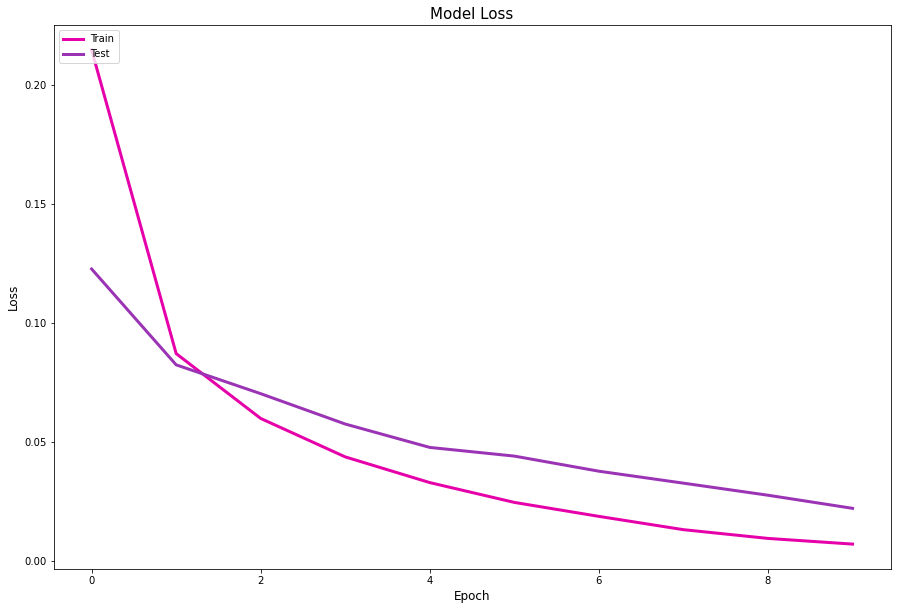

In [54]:
plot_loss(momentum_0_9_history)

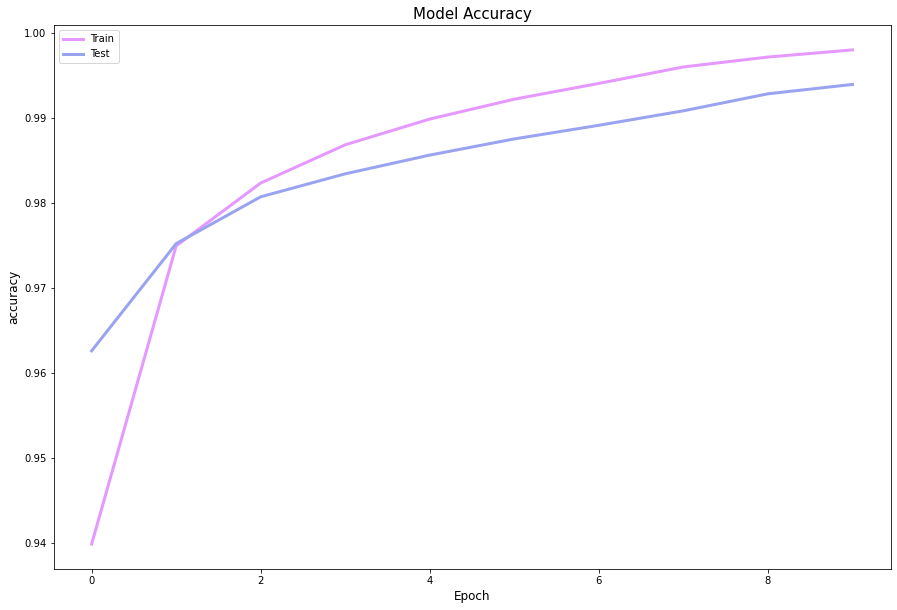

In [55]:
plot_accuracy(momentum_0_9_history)

### Momentum=0.98

In [56]:
momentum_0_98_model = make_feedforward_network(320, 160, optimizer=optimizers.SGD(momentum=0.98)) 

In [57]:
momentum_0_98_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 320)               251200    
_________________________________________________________________
dense_16 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_17 (Dense)             (None, 26)                4186      
Total params: 306,746
Trainable params: 306,746
Non-trainable params: 0
_________________________________________________________________


In [58]:
momentum_0_98_history = momentum_0_98_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
11327/11327 [==============================] - 18s 2ms/step - loss: 0.2668 - accuracy: 0.9256 - val_loss: 0.1899 - val_accuracy: 0.9524
Epoch 2/10
11327/11327 [==============================] - 89s 8ms/step - loss: 0.1671 - accuracy: 0.9556 - val_loss: 0.1648 - val_accuracy: 0.958216s - loss: 0.1724 - accuracy: 0.953 - ETA: 16s - loss: 0.1723 - accuracy: 0.9 - ETA: 17s - loss: 0.1724 - accuracy: 0.95 - ETA: 18s - loss: 0.1723 - accuracy: 0 - ETA: 19s - loss: 0.1725 - accuracy: 0.953 - ETA: 19s - loss: 0.1725 - accuracy: 0. - ETA: 20s - loss: 0.1727 - accuracy: 0.9 - ETA: 20s - loss: 0.1726 - accuracy: 0.9 - ETA: 21s - loss: 0.1727 - accuracy: 0.953 - ETA: 21s - loss: 0.1727 - accuracy: 0.953 - ETA: 22s - loss: 0.1727 - accuracy: 0.95 - ETA: 22s - loss: 0.1726 - accuracy: 0.95 - ETA: 22s - loss: 0.1726 - accuracy: 0. - ETA: 23s - loss: 0.1725 - accuracy: 0.953 - ETA: 24s - loss: 0.1724 - accuracy: 0.95 - ETA: 24s - loss: 0.1725 - accuracy: 0.953 - ETA: 24s - loss: 0.1726 - ac

In [59]:
predict(momentum_0_98_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       417
           1       0.96      0.88      0.92       231
           2       0.97      0.98      0.98       625
           3       0.89      0.94      0.91       284
           4       0.97      0.95      0.96       273
           5       1.00      0.84      0.91        43
           6       0.95      0.95      0.95       166
           7       0.83      0.90      0.87       176
           8       0.97      0.94      0.96        34
           9       0.89      0.96      0.92       244
          10       0.94      0.91      0.92       162
          11       0.98      0.96      0.97       312
          12       0.95      0.99      0.97       310
          13       0.94      0.92      0.93       539
          14       0.98      0.96      0.97      1507
          15       0.96      0.99      0.97       517
          16       0.90      0.91      0.90       151
          17       0.94    

In [60]:
predict(momentum_0_98_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     13453
           1       0.97      0.92      0.95      8437
           2       0.96      0.98      0.97     22784
           3       0.91      0.96      0.93      9850
           4       0.97      0.95      0.96     11167
           5       0.99      0.90      0.94      1120
           6       0.93      0.95      0.94      5596
           7       0.90      0.93      0.91      7042
           8       0.97      0.93      0.95      1086
           9       0.89      0.96      0.93      8249
          10       0.94      0.94      0.94      5441
          11       0.99      0.97      0.98     11274
          12       0.96      0.99      0.98     12026
          13       0.97      0.94      0.96     18471
          14       0.99      0.96      0.97     56318
          15       0.96      0.99      0.98     18824
          16       0.92      0.93      0.92      5661
          17       0.94    

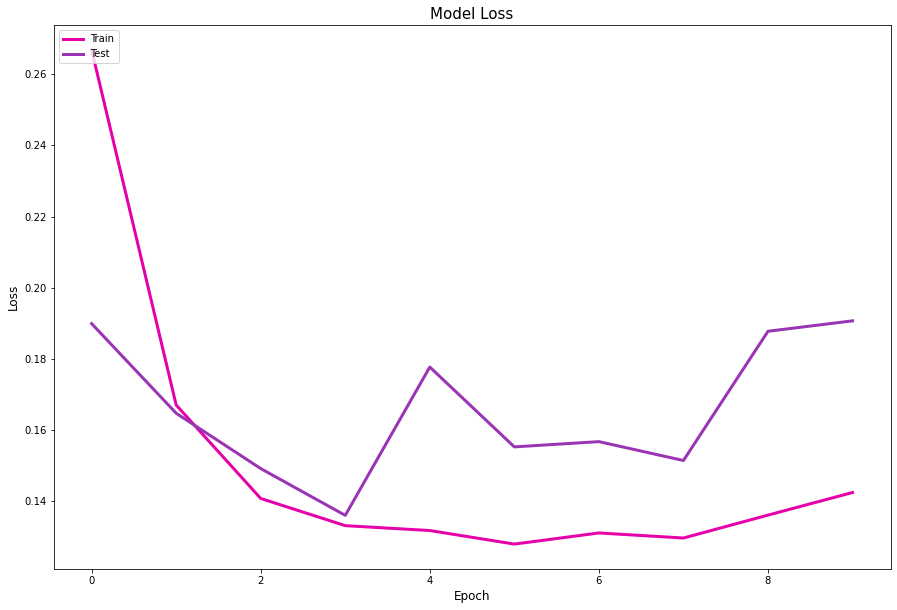

In [61]:
plot_loss(momentum_0_98_history)

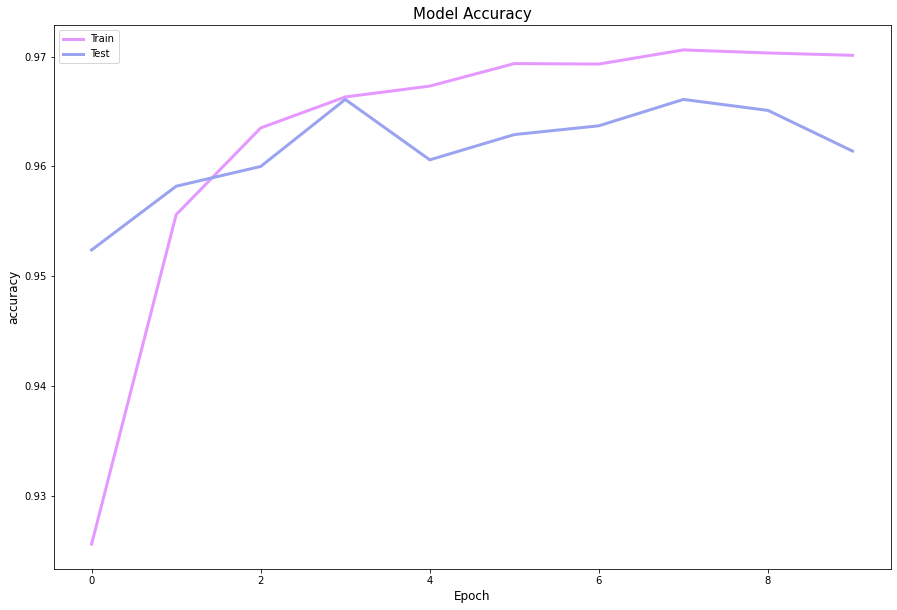

In [62]:
plot_accuracy(momentum_0_98_history)

+  با افزایش Momentum گام‌ها بزرگتر شده در نتیجه وزن‌ها درست به‌روزرسانی نمی‌شوند و گرادیان به مقدار بهینه آن همگرا نخواهد شد. بطور خلاصه افزایش گرادیان لزوما به افزایش دقت نمی‌انجامد. نتایج شبیه‌سازی نشان می‌دهد که بهترین پیش‌بینی مربوط به 0.9 = Momentum می‌باشد. 

+  الگوریتم Adam با گرادیان کاهشی متفاوت است. گرادیان کاهشی یک lr واحد را برای تمام به‌روزرسانی وزن‌ها حفظ می‌کند و این نرخ یادگیری، در طول فرآیند یادگیری مدل تغییر نمی‌کند. در الگوریتم بهینه‌سازی Adam برای هر‌یک از وزن‌های شبکه lr جداگانه‌ای وجود دارد.

In [63]:
adam_model = make_feedforward_network(320, 160, optimizer=optimizers.Adam()) 

In [64]:
adam_model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 320)               251200    
_________________________________________________________________
dense_19 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_20 (Dense)             (None, 26)                4186      
Total params: 306,746
Trainable params: 306,746
Non-trainable params: 0
_________________________________________________________________


In [65]:
adam_history = adam_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
11327/11327 [==============================] - 28s 2ms/step - loss: 0.1834 - accuracy: 0.9474 - val_loss: 0.1057 - val_accuracy: 0.9663
Epoch 2/10
11327/11327 [==============================] - 25s 2ms/step - loss: 0.0838 - accuracy: 0.9753 - val_loss: 0.0742 - val_accuracy: 0.9781
Epoch 3/10
11327/11327 [==============================] - 24s 2ms/step - loss: 0.0621 - accuracy: 0.9813 - val_loss: 0.0679 - val_accuracy: 0.9788
Epoch 4/10
11327/11327 [==============================] - 28s 2ms/step - loss: 0.0499 - accuracy: 0.9848 - val_loss: 0.0677 - val_accuracy: 0.9808
Epoch 5/10
11327/11327 [==============================] - 26s 2ms/step - loss: 0.0427 - accuracy: 0.9868 - val_loss: 0.0547 - val_accuracy: 0.9853
Epoch 6/10
11327/11327 [==============================] - 25s 2ms/step - loss: 0.0377 - accuracy: 0.9884 - val_loss: 0.0802 - val_accuracy: 0.9803
Epoch 7/10
11327/11327 [==============================] - 28s 3ms/step - loss: 0.0348 - accuracy: 0.9897 - val_loss: 0

In [66]:
predict(adam_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       417
           1       1.00      0.98      0.99       231
           2       1.00      0.99      0.99       625
           3       0.94      0.99      0.97       284
           4       0.96      0.99      0.98       273
           5       1.00      0.86      0.92        43
           6       0.97      0.99      0.98       166
           7       0.96      0.98      0.97       176
           8       1.00      0.97      0.99        34
           9       0.98      0.99      0.98       244
          10       0.95      0.99      0.97       162
          11       1.00      0.99      0.99       312
          12       0.98      0.99      0.98       310
          13       0.99      0.98      0.98       539
          14       1.00      0.99      0.99      1507
          15       0.99      1.00      0.99       517
          16       0.99      0.99      0.99       151
          17       1.00    

In [67]:
predict(adam_model, X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13453
           1       1.00      0.99      0.99      8437
           2       1.00      0.99      1.00     22784
           3       0.95      1.00      0.97      9850
           4       0.99      1.00      0.99     11167
           5       1.00      0.98      0.99      1120
           6       0.99      1.00      0.99      5596
           7       0.97      0.99      0.98      7042
           8       0.99      0.99      0.99      1086
           9       0.99      0.99      0.99      8249
          10       0.99      0.98      0.99      5441
          11       0.99      1.00      1.00     11274
          12       1.00      0.99      0.99     12026
          13       0.99      0.99      0.99     18471
          14       1.00      0.99      1.00     56318
          15       1.00      1.00      1.00     18824
          16       0.99      0.99      0.99      5661
          17       1.00    

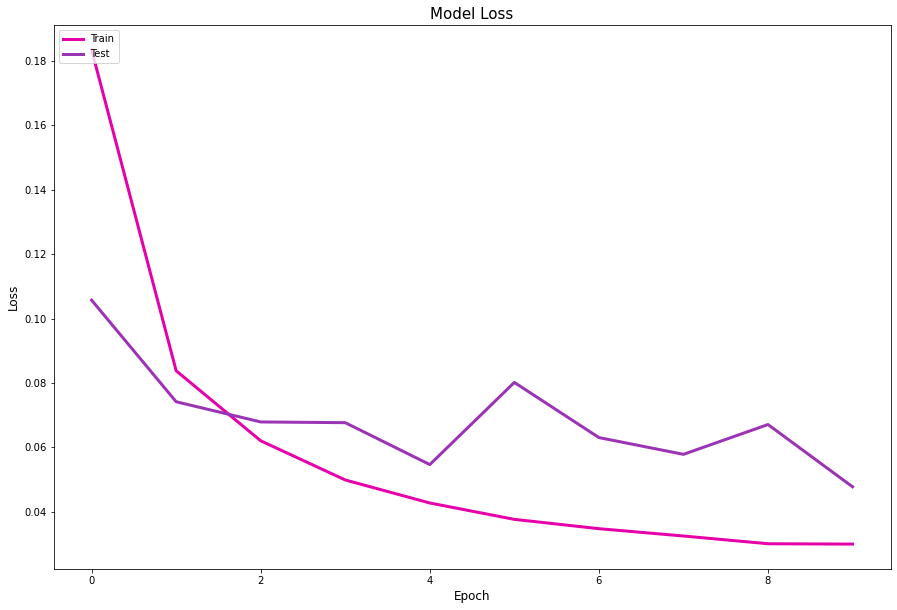

In [68]:
plot_loss(adam_history)

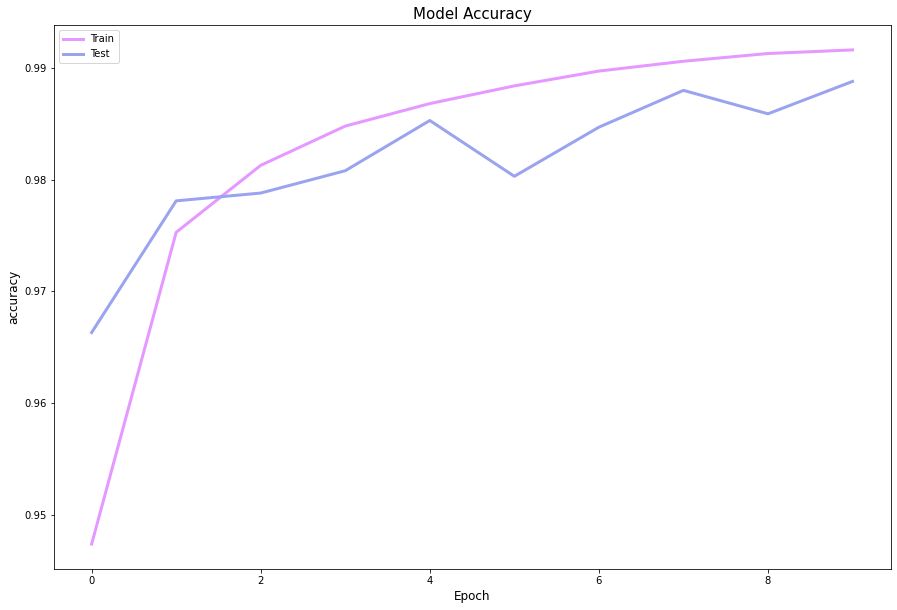

In [69]:
plot_accuracy(adam_history)

مقایسه الگوریتم بهینه‌سازی Adam با SGD نشان می‌دهد که نتایج prediction برای داده‌های train و test بهبود یافته است.

### قسمت دوم) تاثیر تعداد epoch:
+  تعداد epoch برابر 20 در نظر گرفته شده است.

In [70]:
epoch_20_history = adam_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=20)

Epoch 1/20
11327/11327 [==============================] - 29s 3ms/step - loss: 0.0276 - accuracy: 0.9924 - val_loss: 0.0677 - val_accuracy: 0.9875
Epoch 2/20
11327/11327 [==============================] - 26s 2ms/step - loss: 0.0270 - accuracy: 0.9930 - val_loss: 0.0679 - val_accuracy: 0.9857
Epoch 3/20
11327/11327 [==============================] - 25s 2ms/step - loss: 0.0281 - accuracy: 0.9931 - val_loss: 0.0639 - val_accuracy: 0.9880
Epoch 4/20
11327/11327 [==============================] - 29s 3ms/step - loss: 0.0257 - accuracy: 0.9936 - val_loss: 0.0613 - val_accuracy: 0.9897
Epoch 5/20
11327/11327 [==============================] - 26s 2ms/step - loss: 0.0263 - accuracy: 0.9939 - val_loss: 0.0820 - val_accuracy: 0.9870
Epoch 6/20
11327/11327 [==============================] - 28s 2ms/step - loss: 0.0260 - accuracy: 0.9941 - val_loss: 0.0771 - val_accuracy: 0.9894
Epoch 7/20
11327/11327 [==============================] - 30s 3ms/step - loss: 0.0252 - accuracy: 0.9943 - val_loss: 0

In [71]:
predict(adam_model, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       1.00      0.97      0.99       231
           2       1.00      0.99      0.99       625
           3       0.96      0.96      0.96       284
           4       0.97      1.00      0.99       273
           5       0.98      0.95      0.96        43
           6       0.95      0.98      0.96       166
           7       1.00      0.97      0.99       176
           8       1.00      1.00      1.00        34
           9       0.98      0.99      0.98       244
          10       0.98      0.98      0.98       162
          11       1.00      1.00      1.00       312
          12       0.98      0.99      0.99       310
          13       1.00      0.99      0.99       539
          14       1.00      0.99      0.99      1507
          15       0.99      0.99      0.99       517
          16       0.98      0.98      0.98       151
          17       0.99    

In [72]:
predict(adam_model, X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13453
           1       1.00      0.99      0.99      8437
           2       1.00      0.99      1.00     22784
           3       0.99      0.99      0.99      9850
           4       0.99      1.00      1.00     11167
           5       0.99      1.00      0.99      1120
           6       0.97      0.99      0.98      5596
           7       1.00      0.99      0.99      7042
           8       1.00      1.00      1.00      1086
           9       0.99      1.00      0.99      8249
          10       0.99      1.00      0.99      5441
          11       0.99      1.00      0.99     11274
          12       0.99      1.00      1.00     12026
          13       1.00      0.99      0.99     18471
          14       1.00      1.00      1.00     56318
          15       1.00      1.00      1.00     18824
          16       1.00      0.99      0.99      5661
          17       1.00    

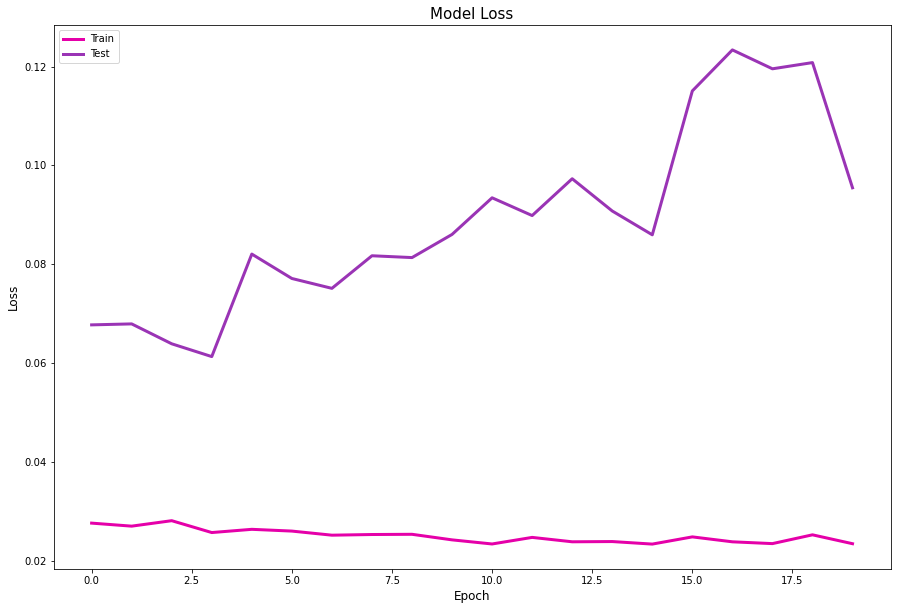

In [73]:
plot_loss(epoch_20_history)

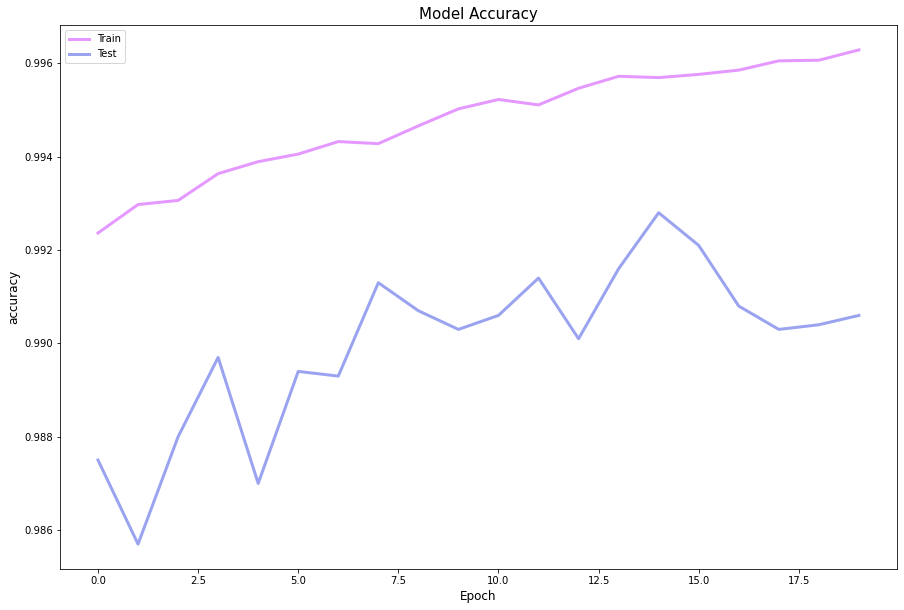

In [74]:
plot_accuracy(epoch_20_history)

+  بله، اگر batch_size برابر با 32 باشد چون اغلب تعداد داده‌های آموزش خیلی زیاد می‌باشد به‌روزرسانی وزن‌ها در هر batch_size انجام خواهد شد. ولی loss و accuracy در هر epoch محاسبه می‌شود و چون در هر epoch تمام داده‌ها مجددا برای بهبود وزن‌ها مورد استفاده قرار می‌گیرند loss و accuracy نیز بهینه می‌شوند. درواقع برای بهتر شدن فرآیند آموزش مدل تعداد epoch‌ها را بزرگ در نظر گرفته می‌شود. البته به شرطی که overfitting رخ ندهد.

+  با افزایش تعداد epoch مدل دچار overfitting خواهد شد. یکی از تکنیک‌های جلوگیری از این مشکل regularization که در قسمت چهارم تست خواهد شد.

### قسمت سوم) تاثیر Loss Function:
+  استفاده از MSE برای مسائل classification مناسب نیست. اول اینکه MSE وقتی استفاده می‌شود که داده‌ها توزیع نرمال داشته باشند، درحالیکه در این پروژه داده‌ها به 26 کلاس تقسیم شده‌اند و توزیع نرمال ندارند. دوم اینکه تابع MSE برای مسائل classification غیر‌محدب است. به عبارت دیگر اگر یک مدل classification با MSE آموزش داده شود تضمینی برای مینیمم شدن تابع loss وجود ندارد.

+  در مسائل regression از تابع هزینه MSE استفاده می‌شود.

In [78]:
mse_adam_model = make_feedforward_network(320, 160, optimizer=optimizers.Adam(), loss=losses.mse) 

In [79]:
mse_adam_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 320)               251200    
_________________________________________________________________
dense_25 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_26 (Dense)             (None, 26)                4186      
Total params: 306,746
Trainable params: 306,746
Non-trainable params: 0
_________________________________________________________________


In [80]:
mse_adam_history = mse_adam_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
11327/11327 [==============================] - 23s 2ms/step - loss: 0.0037 - accuracy: 0.9354 - val_loss: 0.0024 - val_accuracy: 0.9592
Epoch 2/10
11327/11327 [==============================] - 25s 2ms/step - loss: 0.0020 - accuracy: 0.9675 - val_loss: 0.0021 - val_accuracy: 0.9662
Epoch 3/10
11327/11327 [==============================] - 25s 2ms/step - loss: 0.0017 - accuracy: 0.9734 - val_loss: 0.0020 - val_accuracy: 0.9688
Epoch 4/10
11327/11327 [==============================] - 23s 2ms/step - loss: 0.0015 - accuracy: 0.9762 - val_loss: 0.0017 - val_accuracy: 0.9726
Epoch 5/10
11327/11327 [==============================] - 24s 2ms/step - loss: 0.0015 - accuracy: 0.9772 - val_loss: 0.0020 - val_accuracy: 0.9708
Epoch 6/10
11327/11327 [==============================] - 24s 2ms/step - loss: 0.0015 - accuracy: 0.9781 - val_loss: 0.0016 - val_accuracy: 0.9768
Epoch 7/10
11327/11327 [==============================] - 24s 2ms/step - loss: 0.0015 - accuracy: 0.9778 - val_loss: 0

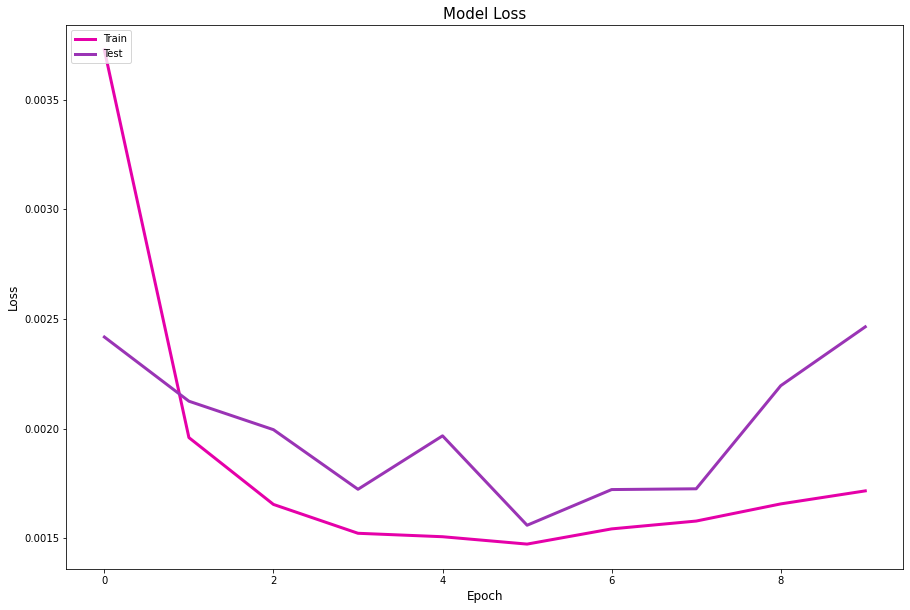

In [81]:
plot_loss(mse_adam_history)

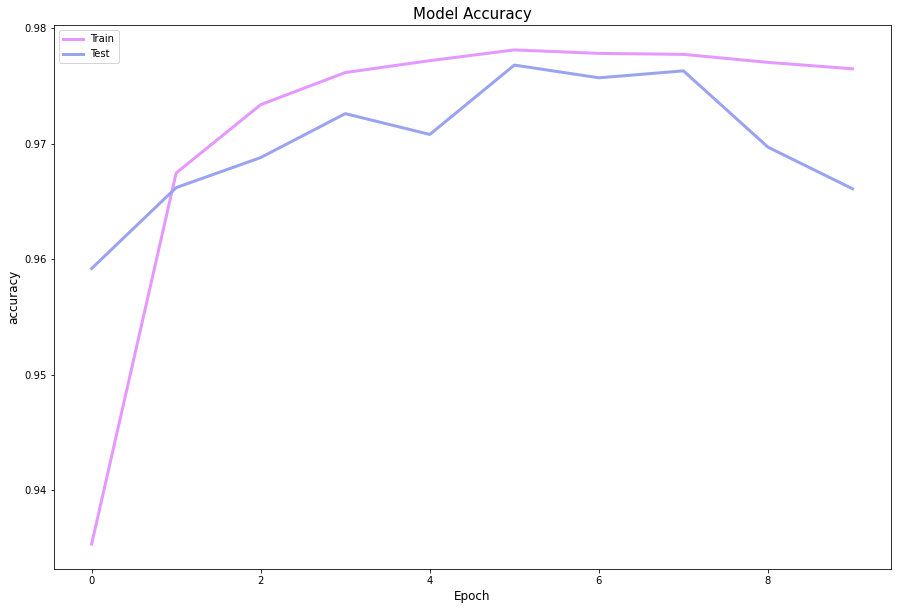

In [82]:
plot_accuracy(mse_adam_history)

### قسمت چهارم) تاثیر regularization:
+  همان‌طور که در قسمت دوم اشاره شد، اگر مدل برای تعداد epoch بالا آموزش داده شود احتمال overfitting افزایش می‌یاید. یکی از روش‌های جلوگیری از overfitting تکنیک regularization است که در ادامه پیاده سازی شده است.

+  هدف از اجرای dropout در مرحله آموزش این است که بعضی از نورون‌ها خاموش شود تا در هر epoch شبکه با epoch قبلی تفاوت داشته باشد.

In [83]:
reg_epoch_20_adam_model = make_feedforward_network(320, 160, optimizer=optimizers.Adam(),regularizer=regularizers.l2(0.0001)) 

In [84]:
reg_epoch_20_adam_model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 320)               251200    
_________________________________________________________________
dense_28 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_29 (Dense)             (None, 26)                4186      
Total params: 306,746
Trainable params: 306,746
Non-trainable params: 0
_________________________________________________________________


In [85]:
reg_epoch_20_adam_history = reg_epoch_20_adam_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=20)

Epoch 1/20
11327/11327 [==============================] - 24s 2ms/step - loss: 0.2675 - accuracy: 0.9451 - val_loss: 0.2021 - val_accuracy: 0.9608
Epoch 2/20
11327/11327 [==============================] - 27s 2ms/step - loss: 0.1772 - accuracy: 0.9694 - val_loss: 0.1580 - val_accuracy: 0.9722
Epoch 3/20
11327/11327 [==============================] - 26s 2ms/step - loss: 0.1570 - accuracy: 0.9733 - val_loss: 0.1539 - val_accuracy: 0.9742
Epoch 4/20
11327/11327 [==============================] - 30s 3ms/step - loss: 0.1476 - accuracy: 0.9748 - val_loss: 0.1457 - val_accuracy: 0.9736
Epoch 5/20
11327/11327 [==============================] - 27s 2ms/step - loss: 0.1411 - accuracy: 0.9759 - val_loss: 0.1513 - val_accuracy: 0.9719
Epoch 6/20
11327/11327 [==============================] - 31s 3ms/step - loss: 0.1374 - accuracy: 0.9763 - val_loss: 0.1432 - val_accuracy: 0.9744
Epoch 7/20
11327/11327 [==============================] - 28s 2ms/step - loss: 0.1345 - accuracy: 0.9769 - val_loss: 0

In [86]:
predict(reg_epoch_20_adam_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       417
           1       0.98      0.95      0.97       231
           2       1.00      0.97      0.98       625
           3       0.95      0.91      0.93       284
           4       0.97      0.98      0.97       273
           5       1.00      0.88      0.94        43
           6       0.95      0.98      0.97       166
           7       0.87      0.97      0.91       176
           8       0.83      1.00      0.91        34
           9       0.97      0.93      0.95       244
          10       0.92      0.98      0.95       162
          11       0.95      1.00      0.97       312
          12       0.98      0.97      0.97       310
          13       0.97      0.98      0.97       539
          14       0.98      0.99      0.98      1507
          15       0.98      0.99      0.98       517
          16       0.97      0.90      0.93       151
          17       0.96    

In [87]:
predict(reg_epoch_20_adam_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     13453
           1       0.98      0.96      0.97      8437
           2       0.99      0.98      0.98     22784
           3       0.95      0.93      0.94      9850
           4       0.97      0.98      0.98     11167
           5       0.98      0.94      0.96      1120
           6       0.97      0.97      0.97      5596
           7       0.91      0.98      0.94      7042
           8       0.89      0.98      0.94      1086
           9       0.97      0.95      0.96      8249
          10       0.95      0.97      0.96      5441
          11       0.96      0.99      0.98     11274
          12       0.99      0.98      0.98     12026
          13       0.98      0.98      0.98     18471
          14       0.98      0.99      0.99     56318
          15       0.99      0.99      0.99     18824
          16       0.98      0.95      0.97      5661
          17       0.98    

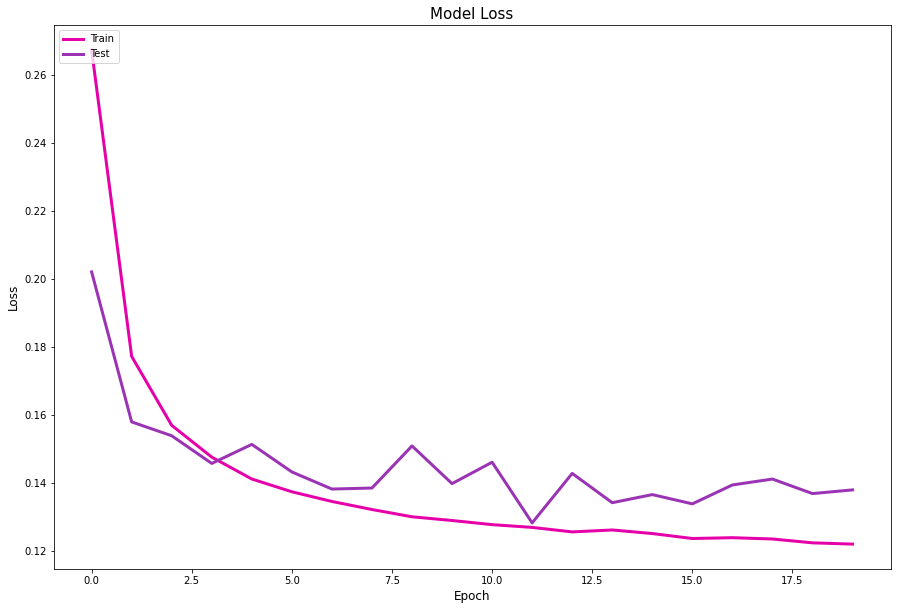

In [88]:
plot_loss(reg_epoch_20_adam_history)

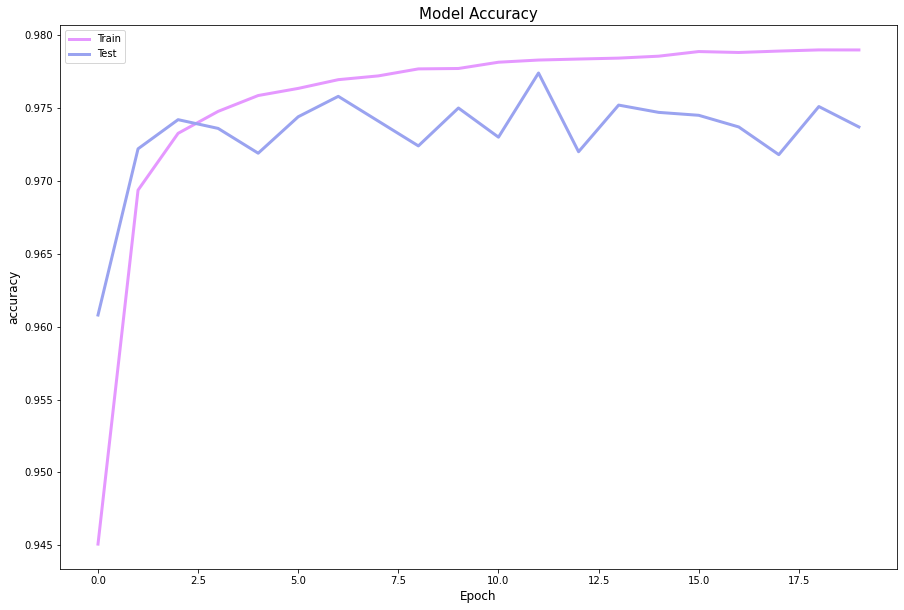

In [89]:
plot_accuracy(reg_epoch_20_adam_history)

In [95]:
def make_feedforward_network_with_dropout(neurons_1st_dense, neurons_2nd_dense, dropout, \
                                          activation='relu', optimizer=optimizers.SGD(lr = 0.01), \
                                          loss=losses.categorical_crossentropy, regularizer=None):
    inp = layers.Input(shape=(28, 28, 1))
    out = layers.Flatten()(inp)
    out = layers.Dense(neurons_1st_dense, activation=activation, kernel_regularizer=regularizer)(out)
    out = layers.Dropout(dropout)(out)
    out = layers.Dense(neurons_2nd_dense, activation=activation, kernel_regularizer=regularizer)(out)
    out = layers.Dropout(dropout)(out)
    out = layers.Dense(N_CLASSES, activation="softmax")(out)

    model = models.Model(inputs=inp, outputs=out) 
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])  
    return model

In [96]:
 dropout_model = make_feedforward_network_with_dropout(320, 160, 0.1, optimizer=optimizers.Adam())  

In [97]:
dropout_model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 320)               251200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 160)               51360     
_________________________________________________________________
dropout_3 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 26)              

In [98]:
dropout_history = dropout_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
11327/11327 [==============================] - 29s 3ms/step - loss: 0.2185 - accuracy: 0.9375 - val_loss: 0.1080 - val_accuracy: 0.9668
Epoch 2/10
11327/11327 [==============================] - 28s 2ms/step - loss: 0.1116 - accuracy: 0.9673 - val_loss: 0.0922 - val_accuracy: 0.9723
Epoch 3/10
11327/11327 [==============================] - 30s 3ms/step - loss: 0.0920 - accuracy: 0.9731 - val_loss: 0.0757 - val_accuracy: 0.9762
Epoch 4/10
11327/11327 [==============================] - 30s 3ms/step - loss: 0.0803 - accuracy: 0.9758 - val_loss: 0.0776 - val_accuracy: 0.9781
Epoch 5/10
11327/11327 [==============================] - 33s 3ms/step - loss: 0.0736 - accuracy: 0.9779 - val_loss: 0.0645 - val_accuracy: 0.9817
Epoch 6/10
11327/11327 [==============================] - 30s 3ms/step - loss: 0.0690 - accuracy: 0.9795 - val_loss: 0.0638 - val_accuracy: 0.9821
Epoch 7/10
11327/11327 [==============================] - 34s 3ms/step - loss: 0.0651 - accuracy: 0.9808 - val_loss: 0

In [100]:
predict(dropout_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       417
           1       0.98      0.94      0.96       231
           2       0.99      0.99      0.99       625
           3       0.96      0.93      0.95       284
           4       0.98      0.99      0.98       273
           5       1.00      0.95      0.98        43
           6       0.98      0.98      0.98       166
           7       0.98      0.95      0.97       176
           8       0.97      1.00      0.99        34
           9       0.96      0.98      0.97       244
          10       0.99      0.98      0.99       162
          11       0.99      0.99      0.99       312
          12       0.99      0.98      0.98       310
          13       0.97      0.99      0.98       539
          14       0.98      0.99      0.99      1507
          15       1.00      0.99      0.99       517
          16       0.97      0.97      0.97       151
          17       0.99    

In [101]:
predict(dropout_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13453
           1       0.99      0.98      0.99      8437
           2       0.99      1.00      0.99     22784
           3       0.98      0.96      0.97      9850
           4       0.99      0.99      0.99     11167
           5       0.97      0.99      0.98      1120
           6       0.99      0.98      0.99      5596
           7       0.99      0.98      0.98      7042
           8       0.98      0.99      0.99      1086
           9       0.97      0.99      0.98      8249
          10       0.99      0.98      0.99      5441
          11       0.99      0.99      0.99     11274
          12       1.00      0.99      0.99     12026
          13       0.98      1.00      0.99     18471
          14       0.99      1.00      0.99     56318
          15       1.00      0.99      1.00     18824
          16       0.99      0.99      0.99      5661
          17       1.00    

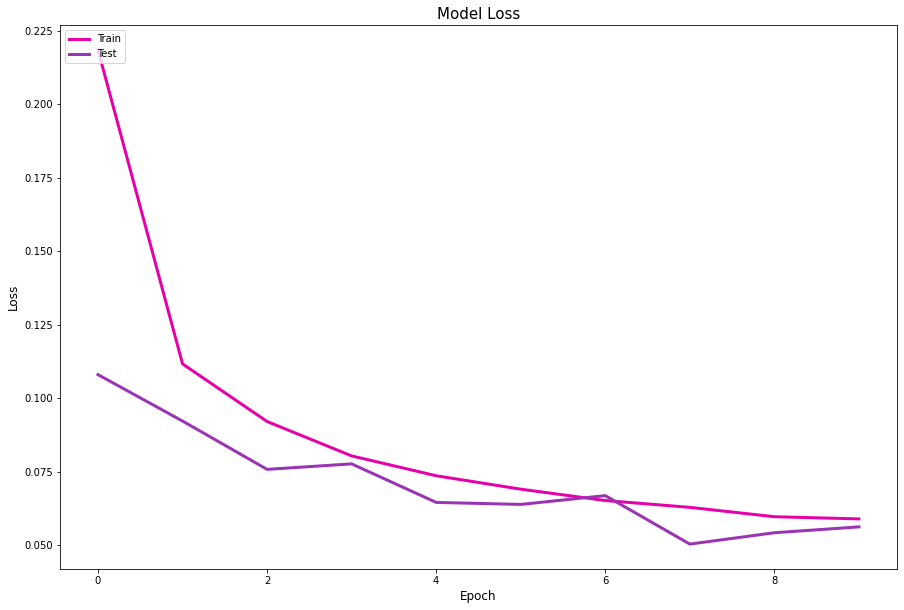

In [102]:
plot_loss(dropout_history)

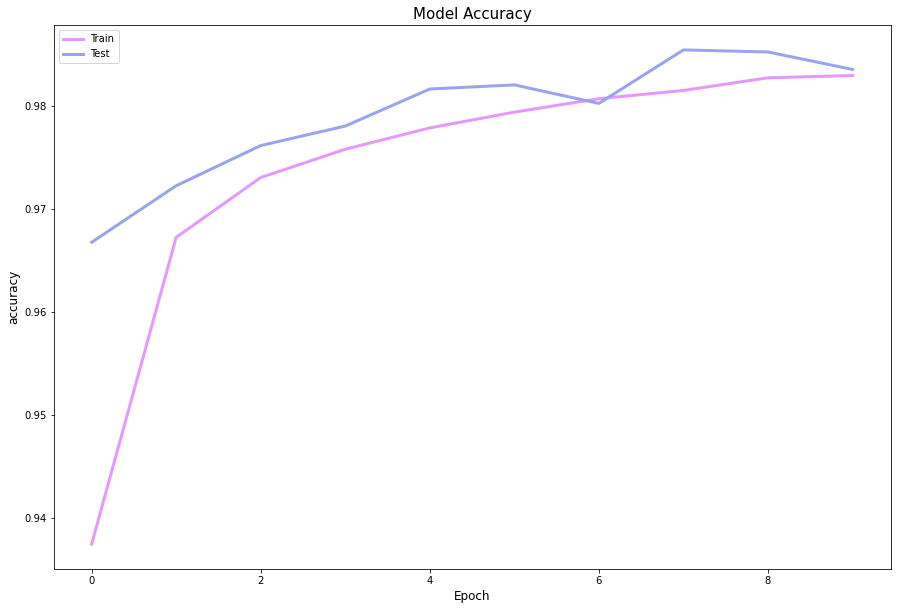

In [99]:
plot_accuracy(dropout_history)